# Preamble

## We're sticking with the Scanpy ecosystem but adding in an additional package called squidpy.

## Dataset Details

Downloaded from GEO: [GSE203424](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE203424)

> Public on Sep 26, 2022

> Title:	INPP5D limits plaque formation and glial reactivity in the APP/PS1 mouse model of Alzheimer’s disease

> Organism: 	Mus musculus

> Summary:	Spatial Transcriptomics (Visium) of 12 coronal brain sections from 6 months old female Inpp5dfl/fl/Cx3cr1CreER/+ crossed to APPKM670/671NL/PSEN1Δexon9 (PSAPP) mice and treated with either cornoil or tamoxifen (75 mg/kg) at 3 months of age for 5 consecutive days

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 200

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

I made an oopsie downloading the data onto the VMs, so execute this to reformat it correctly.

In [3]:
## Important Visium Data Fix

import gzip
from pathlib import Path

def gunzip(f: Path):
    with gzip.open(f, "rb") as infile, open(f.parent / f.stem, "wb") as outfile:
        outfile.write(infile.read())

visium_root = Path("data") / "visium"
accessions = list(set(["_".join(str(p.stem).split("_")[1:3]) for p in visium_root.glob("GSM*")]))

for p in visium_root.glob("*.gz"):
    if p.suffixes[0] in (".json", ".jpg", ".png", ".csv"):
        gunzip(p)

for acc in accessions:
    acc_root = visium_root / acc
    acc_spatial = acc_root / "spatial"
    acc_root.mkdir(exist_ok=True)
    acc_spatial.mkdir(exist_ok=True)
    
    for f in visium_root.glob(f"*{acc}*"):
        if not f.is_file(): continue
        fname = f.name.split(f"{acc}_")[-1]
        if f.suffix == ".h5":
            f.rename(acc_root / fname)
        else:
            f.rename(acc_spatial / fname)

## Loading in the data

Similarly to the scRNA-seq data, there's a function that will easily load what we need into a consolidated AnnData object.

In [5]:
wt_co = sc.read_visium(visium_root / "WT_CO1")
wt_co.var_names_make_unique()

In [6]:
def query_ribosomal_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0005840"]) |\
        biomart_annos.external_gene_name.str.lower().str.match("^m?rp[ls]\d+"),
        "external_gene_name"
    ].dropna().unique()

def query_mitochondrial_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.chromosome_name.str.match("^(mt|MT)") & True,
        "external_gene_name"
    ].dropna().unique()

def query_hemoglobin_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0005833"]),
        "external_gene_name"
    ].dropna().unique()

def annotate_var(adata, species):
    biomart_annos = sc.queries.biomart_annotations(
        species,
        ["external_gene_name", "chromosome_name", "go_id", "start_position", "end_position", "ensembl_gene_id"],
        use_cache=True
    )
    adata.var["hemoglobin"] = adata.var_names.isin(query_hemoglobin_genes(biomart_annos))
    adata.var["mitochondrial"] = adata.var_names.isin(query_mitochondrial_genes(biomart_annos))
    adata.var["ribosomal"] = adata.var_names.isin(query_ribosomal_genes(biomart_annos))
    adata.var["exclude_from_highly_variable"] =  \
        adata.var.hemoglobin | \
        adata.var.mitochondrial |\
        adata.var.ribosomal

In [8]:
annotate_var(wt_co, "mmusculus")

In [9]:
sc.pp.calculate_qc_metrics(
    wt_co,
    log1p=True,
    percent_top=False,
    qc_vars=["mitochondrial", "ribosomal", "hemoglobin"],
    inplace=True
)

In [10]:
wt_co

AnnData object with n_obs × n_vars = 2549 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin'
    var: 'gene_ids', 'feature_types', 'genome', 'hemoglobin', 'mitochondrial', 'ribosomal', 'exclude_from_highly_variable', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

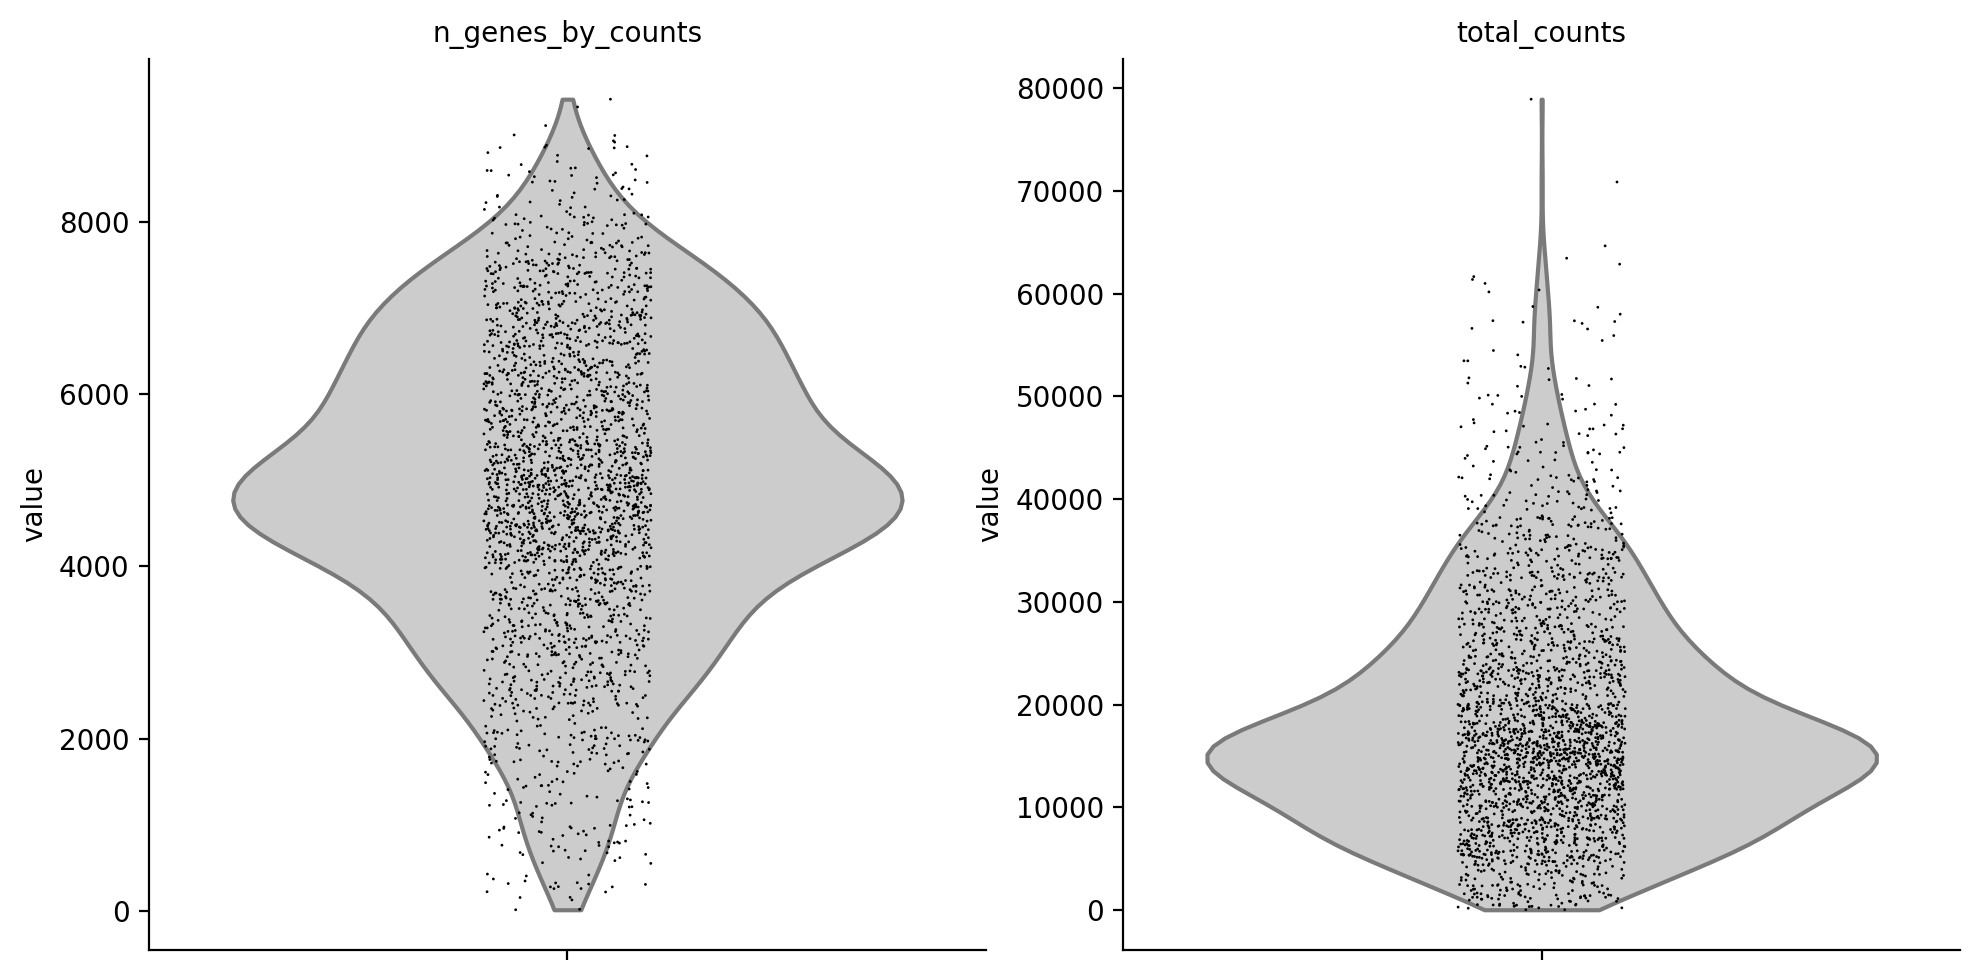

In [12]:
sc.pl.violin(
    wt_co, 
    ["n_genes_by_counts", "total_counts",],
    multi_panel=True, stripplot=True, color="0.8"
)

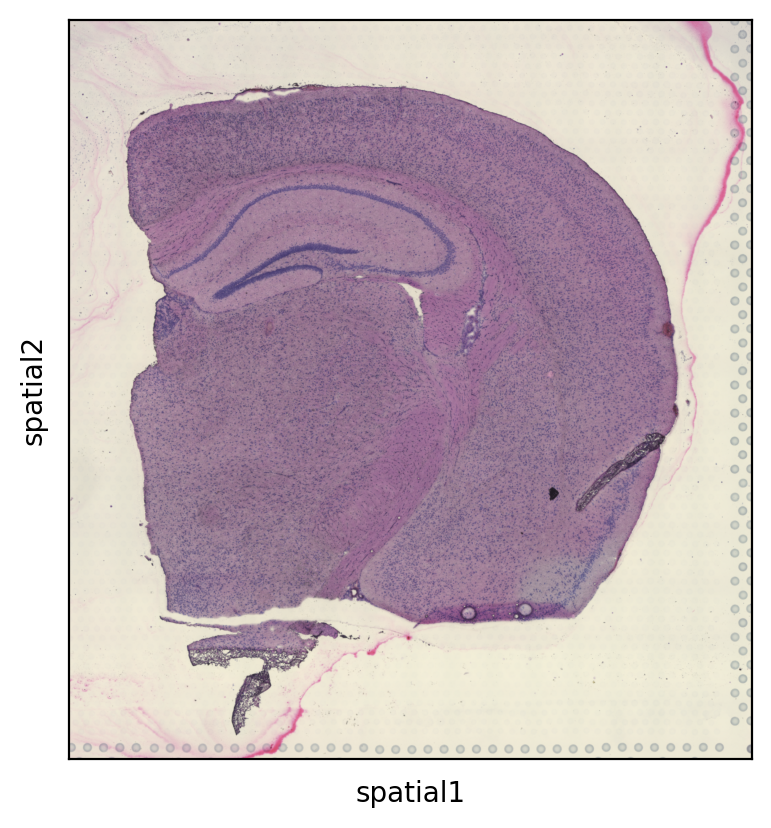

In [14]:
sc.pl.spatial(wt_co)

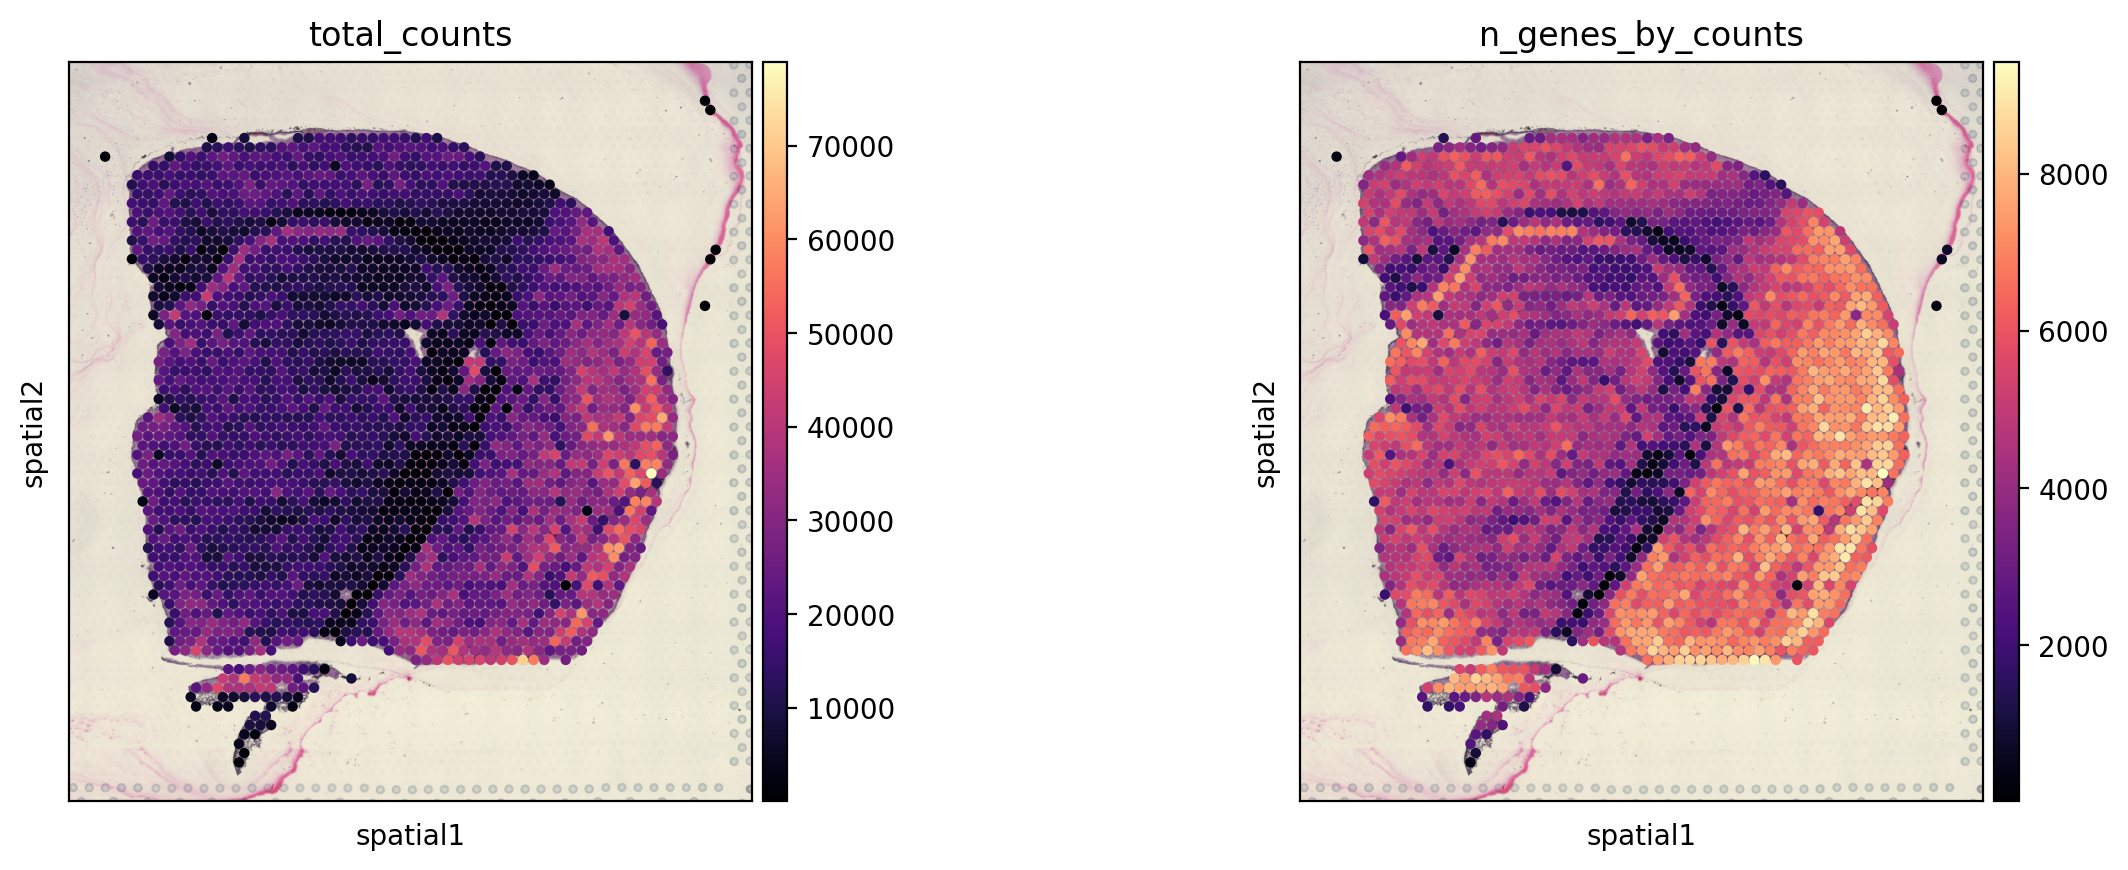

In [15]:
sc.pl.spatial(wt_co, color=["total_counts", "n_genes_by_counts"], size=1.5, cmap="magma")